<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/fast_ai_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting survival of Titanic passengers

Works with fastai version 2.7.11

In [32]:
#!pip install -q fastai --upgrade



In [33]:
import fastai
print(fastai.__version__)

2.7.11


In [31]:
from fastai import *
from fastai.tabular.all import *
import pandas as pd

## Load data

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/AAA/Lesson_5/titanic_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AAA/Lesson_5/titanic_data/test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature engineering
- Extract *Title* from the name colum. 
- Extract *Deck* from the first character of the cabin number.
- Fill in missing *Age* values with the mean age for passengers with the same title.

In [6]:
for df in [train_df, test_df]:
    df['Title'] = df['Name'].str.split(',').str[1].str.split(' ').str[1]
    df['Deck'] = df['Cabin'].str[0]

# find mean age for each Title across train and test data sets
all_df = pd.concat([train_df, test_df], sort=False)
mean_age_by_title = all_df.groupby('Title').mean()['Age']
# update missing ages
for df in [train_df, test_df]:
    for title, age in mean_age_by_title.iteritems():
        df.loc[df['Age'].isnull() & (df['Title'] == title), 'Age'] = age

In [ ]:
test_df.Fare.fillna(0,inplace=True)

In [8]:
train_df['Title']

0        Mr.
1       Mrs.
2      Miss.
3       Mrs.
4        Mr.
       ...  
886     Rev.
887    Miss.
888    Miss.
889      Mr.
890      Mr.
Name: Title, Length: 891, dtype: object


## Fastai setup

In [9]:

dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
cont_names = ['Age', 'Fare', 'SibSp', 'Parch']
procs = [FillMissing,Categorify, Normalize] #, 

The last part is the list of pre-processors we apply to our data:

1. `Categorify` is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
2. `FillMissing` will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
3. `Normalize` will normalize the continuous variables (subtract the mean and divide by the std)


In [36]:
train_df.shape

(891, 14)

In [17]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names=cat_names ,
                   cont_names = cont_names,
                   y_names=dep_var,
                   splits=splits,
                   y_block = CategoryBlock) # when y's are 0/1 but we don't want to do regression
dls = to.dataloaders(bs=64) # dataloaders

In [37]:
to.xs.shape

(891, 9)

In [22]:
learn = tabular_learner(dls, metrics=accuracy)

The following command does a preview of the model. ´LinBnDrop` is a Module grouping `BatchNorm1d`, `Dropout` and Linear layers

In [35]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(4, 3)
    (3): Embedding(18, 8)
    (4): Embedding(9, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=26, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

Method `lr_find` helps to find a good learning rate. 

SuggestedLRs(valley=0.002511886414140463)

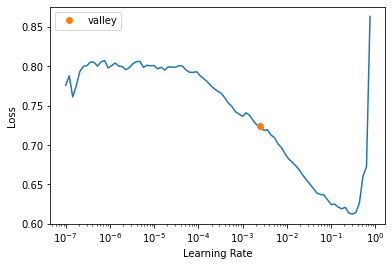

In [19]:
learn.lr_find()

In [23]:
learn.fit(30, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.657541,0.642845,0.679775,00:00
1,0.604375,0.613646,0.696629,00:00
2,0.554601,0.522374,0.803371,00:00
3,0.520602,0.468981,0.803371,00:00
4,0.496077,0.438366,0.825843,00:00
5,0.476701,0.394502,0.831461,00:00
6,0.462008,0.411577,0.837079,00:00
7,0.446310,0.395334,0.870786,00:00
8,0.437738,0.406610,0.837079,00:00
9,0.427457,0.394434,0.865169,00:00
